<a href="https://colab.research.google.com/github/sedaoturak/dcgan_cahn-hilliard/blob/main/DCGAN_Cahn_Hillard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm.notebook

# Load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_input_patterns_64_x_64.txt', 'r') as f: 
  g = np.loadtxt(f)
with open('/content/drive/MyDrive/toy_datasets/Mechanical_MNIST/Case1_strain_energy.txt', 'r') as f:
  e = np.loadtxt(f)

Mounted at /content/drive


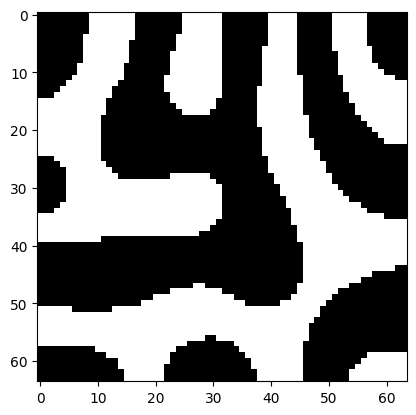

In [3]:
# visualize an image from dataset
img = g.reshape(37523,64,64)
plt.imshow(img[9,:,:], interpolation='nearest', cmap='binary')
plt.show()

In [4]:
# normalize the strain energy values
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
scaler = MinMaxScaler(feature_range=(0,1))

e_scaled = scaler.fit_transform(e[:,6].reshape(-1, 1))
e_power = pt.fit_transform(e[:,6].reshape(-1, 1))
e_power_scaled = scaler.fit_transform(e_power)
e_scaled.shape, e_scaled.ravel().shape

images = g.reshape((37523,64,64))
energies = e_power_scaled.ravel()

images.shape, energies.shape

((37523, 64, 64), (37523,))

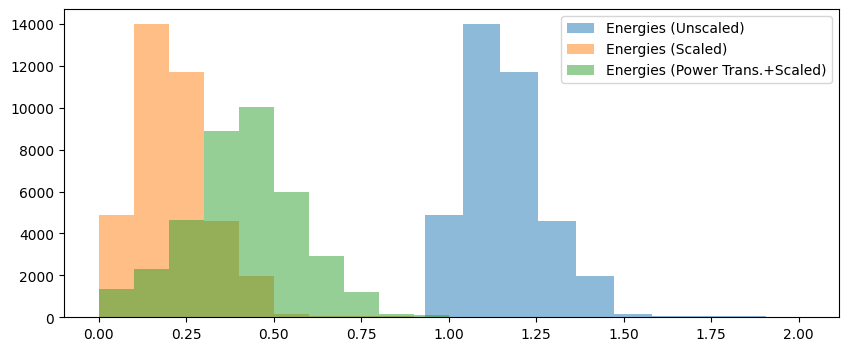

In [5]:
fig, axs = plt.subplots(figsize=(10,4))

axs.hist(e[:,6], label=f'Energies (Unscaled)', alpha=0.5)
axs.hist(e_scaled, label=f'Energies (Scaled)', alpha=0.5)
# axs.hist(e_power, label=f'Energies (Power Trans.)', alpha=0.5)
axs.hist(e_power_scaled, label=f'Energies (Power Trans.+Scaled)', alpha=0.5)
axs.legend()

In [5]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
  def __init__(self, imgs, labels, transform):
    self.labels = labels
    self.imgs = imgs
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    if self.labels is None:
      x = self.imgs[index]
      x = self.transform(x)
      return x
    else:
      x = self.imgs[index]
      x = self.transform(x)
      y = self.labels[index]
    return x, y

b, w, h, = [*images.shape]
print(images.shape)
images_wb = np.repeat(images[..., np.newaxis], 1, -1)
print(images_wb.shape)
images_wb = images_wb.reshape(b, 1, w, h)
print(images_wb.shape)

(37523, 64, 64)
(37523, 64, 64, 1)
(37523, 1, 64, 64)


In [6]:
transform = transforms.Compose([
      # transforms.Resize((32, 32)),
        ])

# Datasets
normalized_images = images_wb
data = torch.tensor(normalized_images, dtype=torch.float32)
target = torch.tensor(energies, dtype=torch.float32).reshape(-1,1)

if __name__ == "__main__":
  dataset = CustomDataset(data, target, transform)

In [7]:
# train-test split
train_set_size = int(len(dataset)*0.8)
val_set_size = len(dataset) - train_set_size

trainset, valset  = random_split(dataset, [train_set_size, val_set_size])
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers= 2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers= 2)

# Model

https://github.com/Yuumna/GAN-PyTorch/blob/main/DCGAN_batch_normalization.ipynb

In [71]:
def get_discriminator_block( input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
  if not final_layer:
    return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      nn.BatchNorm2d(output_channels),
      nn.LeakyReLU(0.2, inplace=True) )
  else: 
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride)
    )

In [72]:
class Discriminator(nn.Module):
  '''im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is the default)
    hidden_dim: the inner dimension, a scalar
  '''
  def __init__(self, im_chan=1, hidden_dim=16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        get_discriminator_block(im_chan, hidden_dim),
        get_discriminator_block(hidden_dim, hidden_dim * 2),
        get_discriminator_block(hidden_dim * 2, 1, final_layer=True) )

  def forward(self, image):
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred), -1)

In [73]:
def get_generator_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
  if not final_layer:
    return nn.Sequential(
      nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(inplace=True) )
  else: 
    return nn.Sequential(
      nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
      nn.Sigmoid() )

In [74]:
class Generator(nn.Module):
  '''z_dim: the dimension of the noise vector, a scalar
     im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is the default)
     hidden_dim: the inner dimension, a scalar
  '''
  def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        get_generator_block(hidden_dim * 2, hidden_dim),
        get_generator_block(hidden_dim, im_chan, kernel_size=4, final_layer=True) )

  def forward(self, noise):
    '''
    Function for completing a forward pass of the generator: Given a noise tensor, 
    returns generated images.
    Parameters:
    noise: a noise tensor with dimensions (n_samples, z_dim)
    '''
    x = noise.view(len(noise), self.z_dim, 1, 1)
    return self.gen(x)

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

z_dim = 64

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

criterion = torch.nn.MSELoss(reduction='mean')
lr = 0.0002 #learning_rate
beta_1 = 0.5 
beta_2 = 0.999

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [76]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [77]:
def get_noise(n_samples, z_dim, device='cpu'):
  '''
  Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
  creates a tensor of that shape filled with random numbers from the normal distribution.
  Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
  '''
  return torch.randn(n_samples,z_dim,device=device)

In [78]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
  '''
  Return the loss of the discriminator given inputs.
  Parameters:
      gen: the generator model, which returns an image given z-dimensional noise
      disc: the discriminator model, which returns a single-dimensional prediction of real/fake
      criterion: the loss function, which should be used to compare 
              the discriminator's predictions to the ground truth reality of the images 
              (e.g. fake = 0, real = 1)
      real: a batch of real images
      num_images: the number of images the generator should produce, 
              which is also the length of the real images
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
  Returns:
      disc_loss: a torch scalar loss value for the current batch
  '''
  fake_noise = get_noise(num_images, z_dim, device=device)
  fake = gen(fake_noise)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(real)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2

  return disc_loss

In [79]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
  '''
  Return the loss of the generator given inputs.
  Parameters:
      gen: the generator model, which returns an image given z-dimensional noise
      disc: the discriminator model, which returns a single-dimensional prediction of real/fake
      criterion: the loss function, which should be used to compare 
              the discriminator's predictions to the ground truth reality of the images 
              (e.g. fake = 0, real = 1)
      num_images: the number of images the generator should produce, 
              which is also the length of the real images
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
  Returns:
      gen_loss: a torch scalar loss value for the c1urrent batch
  '''
  fake_noise = get_noise(num_images, z_dim, device=device)
  fake = gen(fake_noise)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

  return gen_loss

In [82]:
n_epochs = 50
display_step = 500
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

# Keep track of losses
disc_losses = []
gen_losses = []

test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  # Dataloader returns the batches
  for real, _ in tqdm(trainloader):
    cur_batch_size = len(real)

    real = real.to(device)

    ### Update discriminator ###
    # Zero out the gradients before backpropagation
    disc_opt.zero_grad()

    # Calculate discriminator loss
    disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
    disc_losses.append(disc_loss.item())

    # Update gradients
    disc_loss.backward(retain_graph=True)

    # Update optimizer
    disc_opt.step()

    # For testing purposes, to keep track of the generator weights
    if test_generator:
      old_generator_weights = gen.gen[0][0].weight.detach().clone()

    gen_opt.zero_grad()
    gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
    gen_losses.append(gen_loss.item())
    gen_loss.backward()
    gen_opt.step()

    # For testing purposes, to check that your code changes the generator weights
    if test_generator:
      try:
        assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
        assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
      except:
        error = True
        print("Runtime tests have failed")

    # Keep track of the average discriminator loss
    mean_discriminator_loss += disc_loss.item() / display_step

    # Keep track of the average generator loss
    mean_generator_loss += gen_loss.item() / display_step

    ### Visualization code ###
    # if cur_step % display_step == 0 and cur_step > 0:
    #   print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
    #   fake_noise = get_noise(cur_batch_size, z_dim, device=device)
    #   fake = gen(fake_noise)
    #   show_tensor_images(fake)
    #   show_tensor_images(real)
    #   mean_generator_loss = 0
    #   mean_discriminator_loss = 0
    cur_step += 1

100%|██████████| 470/470 [00:05<00:00, 84.26it/s]


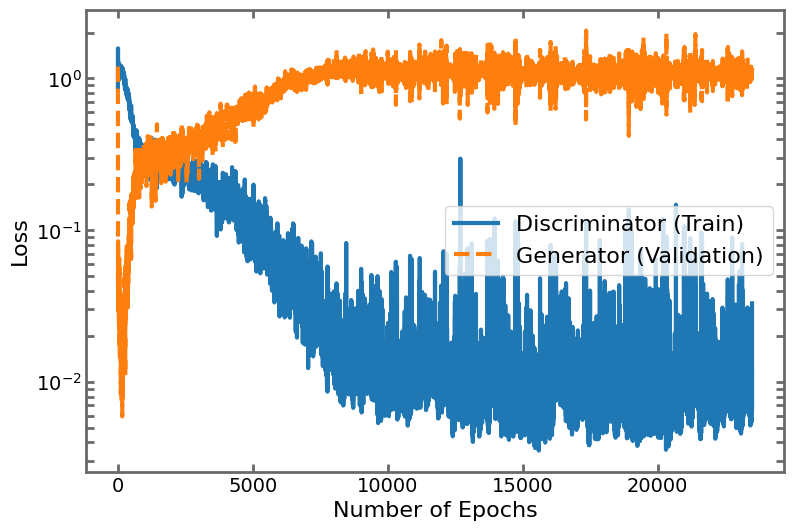

In [86]:
fig, ax = plt.subplots(figsize=(9, 6))
font_size=16
tick_size=14

ax.plot(disc_losses, '-', label='Discriminator (Train)', linewidth=3)
ax.plot(gen_losses,'--', label='Generator (Validation)', linewidth=3)

ax.set_ylabel('Loss', fontsize=font_size)
ax.set_xlabel('Number of Epochs', fontsize=font_size)
ax.set_yscale('log')

ax.xaxis.set_tick_params(width=2, length=5, labelsize=tick_size, color='dimgrey')
ax.yaxis.set_tick_params(width=2, length=5, labelsize=tick_size, color='dimgrey')
ax.tick_params(which='both', width=2, length=6, top=True, right=True, direction='in', color='dimgrey')
plt.setp(ax.spines.values(), linewidth=2, color='dimgrey')
ax.legend(fontsize=font_size)

In [ ]:
epochs = 1

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    # beta annealing
    if epoch<30:
      beta=0
    else:
      beta=0.5e-4

    ztrain, train_epoch_loss = train(trainloader, trainset, beta)
    zval, valid_epoch_loss = validate(valloader, valset, beta)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

In [ ]:
# save model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
torch.save(model, os.path.join(PATH, f'mech_MNIST_entire.pt'))

# model_scripted = torch.jit.script(model.cpu())
# model_scripted.save(os.path.join(PATH, f'mech_MNIST_scripted.pt'))

In [ ]:
# load trained model
import os
PATH = '/content/drive/MyDrive/Colab Notebooks'
model = torch.load(os.path.join(PATH, f'mech_MNIST_entire.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reconstructed Images

In [87]:
len(trainloader.dataset.indices)

30018

In [ ]:
original_images = []
reconstructed_images = []
z_train = np.zeros((0,16))
idx_train = []
strain_energy = np.zeros((0,1))
for i, (d,t) in tqdm(enumerate(trainloader)):
  d = d.to(device)
  t = t.to(device)
  z, _, _, out = generator(d,t)
  original_images.append(d.cpu().detach().numpy())
  reconstructed_images.append(out.cpu().detach().numpy())
  z_train = np.vstack([z_train,z.cpu().detach().numpy()])
  strain_energy = np.vstack([strain_energy, t.cpu().detach().numpy()])
strain_energy = strain_energy.ravel()